<h1>Zero Shot Learning<h1>
<h4>Here we classify our tweets with the zero shot learning method<h4>

In [1]:
#importing the python libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import transformers
import dill
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
#importing the dataset with raw tweets
test_df = pd.read_pickle('./test_df.pkl')

FileNotFoundError: [Errno 2] No such file or directory: './test_df.pkl'

In [4]:
#importing the cleaned tweets
test_df_cleaned = pd.read_pickle('./test_df_cleaned.pkl')

<h4>Below is the helper function to calcualte the evaluation metric and plot the ROC curves<h4>

In [5]:
def performance(y_true,y_predict,y_proba=[]):
    TP = confusion_matrix(y_true,y_predict)[0,0]
    FP = confusion_matrix(y_true,y_predict)[0,1]
    TN = confusion_matrix(y_true,y_predict)[1,1]
    FN = confusion_matrix(y_true,y_predict)[1,0]
    TN, FP, FN, TP = confusion_matrix(y_true,y_predict).ravel()
    print(f"Accuracy: {round(((TP+TN)/(TP+TN+FP+FN))*100,3)}%")
    precision = round((TP/(TP+ FP))*100,3)
    recall = round((TP/(TP+ FN))*100,3)
    print(confusion_matrix(y_true,y_predict,labels=[1,0]).ravel())
    print(f"TP: {TP}")
    print(f"FP: {FP}")
    print(f"TN: {TN}")
    print(f"FN: {FN}")
    print(f"Sensitivity: {round((TP/(TP+ FN))*100,3)}%")
    print(f"Specificity: {round((TN/(TN + FP))*100,3)}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"f1: {round(((2*precision*recall)/(precision+recall)),3)}%")
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix(y_true,y_predict,labels=[1,0]), display_labels=[1,0])
    cm_display.plot()
    plt.show()
    if (y_proba!=[]):
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_true,y_proba)
        print(thresholds)
        area = metrics.auc(false_positive_rate, true_positive_rate)
        plt.figure()
        plt.plot(false_positive_rate, true_positive_rate, color='green', lw=2, label=f'ROC curve (Area Under Curve = {area:.2f})')
        plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

In [11]:
#initialise the zero shot classifier (BERT variant)
classifier = transformers.pipeline("zero-shot-classification",model="bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [12]:
#helper function to perform testing
def zero_shot_learning(row):
    message = row
    labels = ["Carbon Capture and Storage","Other"]
    try:
        zsl_result = classifier(message, labels)
        predicted_class = zsl_result['labels'][0]
    except Exception as e:
        print("For the tweet => ",message)
        print("Error => ",e)
    if (predicted_class == labels[0]):
        return 1
    elif(predicted_class == labels[1]):
        return 0

In [8]:
#remove the empty rows (if exists) after cleaning the tweets
test_df_cleaned['tweet_preprocessed'].replace('', np.nan, inplace=True)
test_df_cleaned = test_df_cleaned.dropna(subset=['tweet_preprocessed'])
test_df_cleaned

,level_0,index,author_id,geo,tweetid,lang,like_count,quote_count,reply_count,retweet_count,...,ccs_score,rowid,relevant_manualscore,related_score_based,related_manual,tweet_preprocessed,tweet_tokenized_preprocessed,tweet_word2vec_preprocessed,context_domain_name,context_word2vec
0,1,196,1150771325721546754,7d7bdec12d2549d4,1640409818140639232,en,6,0,0,1,...,0,1019,None,0,1.0,feb ground broken new bluecoat academy carring...,"[feb, ground, broken, new, bluecoat, academy, ...","[-0.17708985341295344, -0.09123214083755839, 0...",[unknown],"[0.00023176193644758314, -0.001168469781987369..."
1,20,1000,1233114093629976582,25d3e991f5637f5a,1630937495616495617,en,1,0,0,0,...,0,5018,None,0,1.0,seagrass vital habitat cuttlefish species func...,"[seagrass, vital, habitat, cuttlefish, species...","[-0.32027924060821533, -0.1663591515272856, 0....",[unknown],"[0.00023176193644758314, -0.001168469781987369..."
2,37,2340,20662440,25d3e991f5637f5a,1614419209798258688,en,17,0,1,2,...,0,11679,None,0,1.0,know buying land improve biodiversity carbon s...,"[know, buying, land, improve, biodiversity, ca...","[-0.24470218703808153, -0.021547190833028734, ...",[unknown],"[0.00023176193644758314, -0.001168469781987369..."
3,44,3027,265276284,7ae9e2f2ff7a87cd,1605479146288664576,en,1,0,0,0,...,0,15099,None,0,1.0,aye theres rub tradeoffs optimising annual car...,"[aye, theres, rub, tradeoffs, optimising, annu...","[-0.2432087640399518, -0.07931409381410998, -0...",[unknown],"[0.00023176193644758314, -0.001168469781987369..."
4,126,300,20662440,06168d1feda43857,1639341574445309952,en,0,0,1,0,...,20,1535,None,1,1.0,ccs knowledge sticking carbon capture fossil f...,"[ccs, knowledge, sticking, carbon, capture, fo...","[-0.240239797733151, -0.028277638601139188, -0...",[unknown],"[0.00023176193644758314, -0.001168469781987369..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,68908,392963,187602448,53b67b1d1cc81a51,988687454143205377,en,2,0,0,0,...,1,1169123,None,1,0.0,absolutely silos getting deepertotal new envir...,"[absolutely, silos, getting, deepertotal, new,...","[-0.12502856420663497, 0.07465614553075284, -0...",[unknown],"[0.00023176193644758314, -0.001168469781987369..."
496,70708,423866,388793955,25d3e991f5637f5a,954077360709619712,en,1,0,0,0,...,1,1200261,None,1,0.0,total waste time year olds regimented learning...,"[total, waste, time, year, olds, regimented, l...","[-0.19740079971961677, -0.09446627937722951, -...",[unknown],"[0.00023176193644758314, -0.001168469781987369..."
497,71356,194500,2831955446,720081c4c09a4a84,1198915726486228992,en,1,0,0,0,...,1,870955,None,1,0.0,bp needs resolve environmental issues goes phi...,"[bp, needs, resolve, environmental, issues, go...","[-0.14111729338765144, -0.16012865105377777, 0...","[brand, vertical]","[-0.007221590261906385, 0.0060702532064169645,..."
498,71358,194851,2273675919,1f36c2b60fbc98ac,1198533532781568001,en,65,1,5,3,...,1,872356,None,1,0.0,watched blues leicester game defensive shift c...,"[watched, blues, leicester, game, defensive, s...","[-0.032119659171439705, 0.09410803392529488, -...",[brand],"[-0.00477095041424036, 0.004586540162563324, 0..."


In [18]:
#zero shot prediction for raw tweets (BERT variant)
%%time
test_df['related_zero_shot_tweet_original'] = test_df['tweet_original'].apply(zero_shot_learning)

CPU times: user 18min 49s, sys: 1min 9s, total: 19min 58s
Wall time: 1min 52s


In [13]:
#zero shot prediction for cleaned tweets (BERT variant)
%%time
test_df_cleaned['related_zero_shot_tweet_cleaned'] = test_df_cleaned['tweet_preprocessed'].apply(zero_shot_learning)

CPU times: user 15min 48s, sys: 1min 4s, total: 16min 53s
Wall time: 1min 37s


Classification : Original tweet, Manual
Accuracy: 79.4%
[223  27  76 174]
TP: 223
FP: 76
TN: 174
FN: 27
Sensitivity: 89.2%
Specificity: 69.6%
Precision: 74.582%
Recall: 89.2%
f1: 81.239%


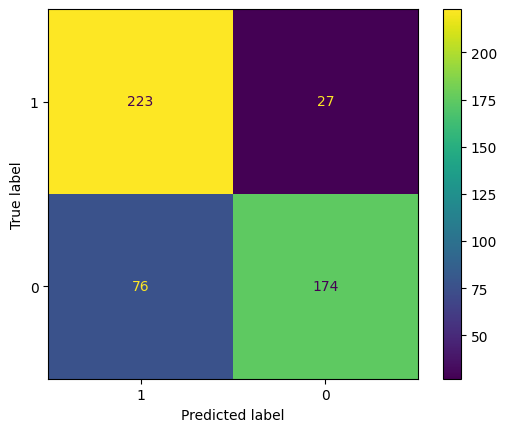

[inf  1.  0.]


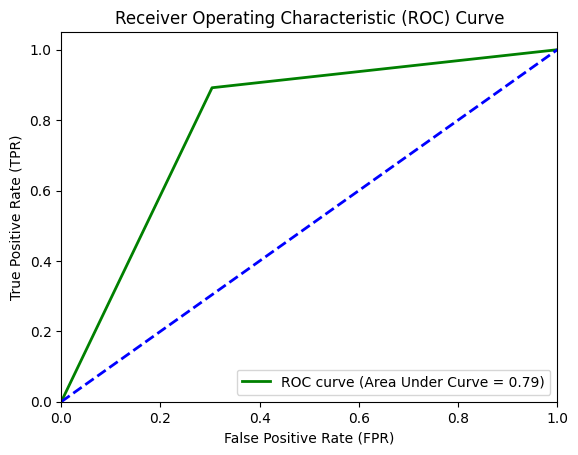

In [186]:
#Print performance report for raw tweet
print("Classification : Original tweet, Manual")
performance(test_df['related_manual'],test_df['related_zero_shot_tweet_original'])

Classification : Preprocessed tweet, Manual
Accuracy: 81.69%
[244   6  85 162]
TP: 244
FP: 85
TN: 162
FN: 6
Sensitivity: 97.6%
Specificity: 65.587%
Precision: 74.164%
Recall: 97.6%
f1: 84.283%


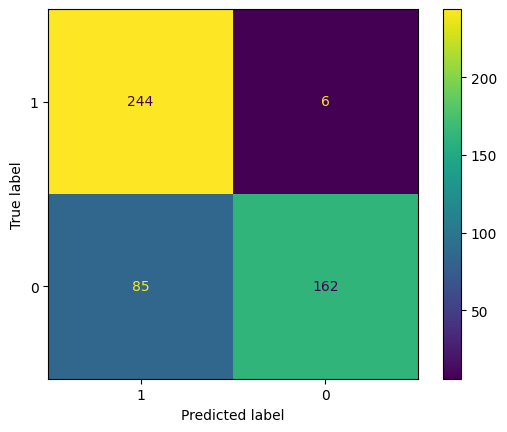

[inf  1.  0.]


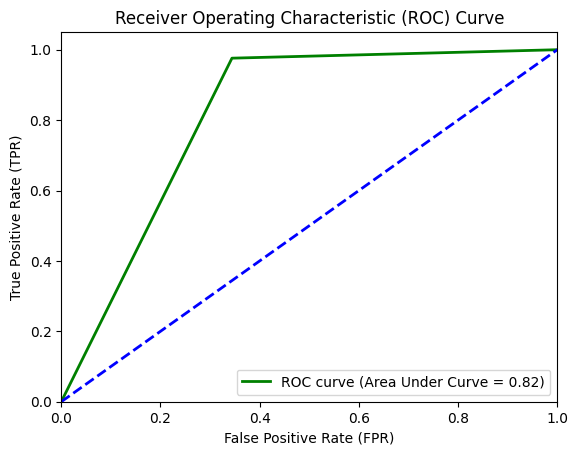

In [23]:
#performance for cleaned tweets
print("Classification : Preprocessed tweet, Manual")
performance(test_df_cleaned['related_manual'],test_df_cleaned['related_zero_shot_tweet_cleaned'],list(test_df_cleaned['related_zero_shot_tweet_cleaned']))

In [18]:
#Helper function for zero shot BART
def zero_shot_learning_bart(row):
    message = row
    labels = ["Carbon Capture and Storage","Other"]
    try:
        zsl_result = classifier_bart(message, labels)
        predicted_class = zsl_result['labels'][0]
    except Exception as e:
        print("For the tweet => ",message)
        print("Error => ",e)
    if (predicted_class == labels[0]):
        return 1
    elif(predicted_class == labels[1]):
        return 0

In [15]:
#initialise model for BART
classifier_bart = transformers.pipeline("zero-shot-classification")

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [8]:
#zero shot prediction for raw tweets (BART)
%%time
test_df['related_zero_shot_tweet_original_bart'] = test_df['tweet_original'].apply(zero_shot_learning_bart)

CPU times: user 1h 22min 19s, sys: 5min 2s, total: 1h 27min 21s
Wall time: 8min 17s


Accuracy: 70.0%
[117 133  17 233]
TP: 117
FP: 17
TN: 233
FN: 133
Sensitivity: 46.8%
Specificity: 93.2%
Precision: 87.313%
Recall: 46.8%
f1: 60.937%


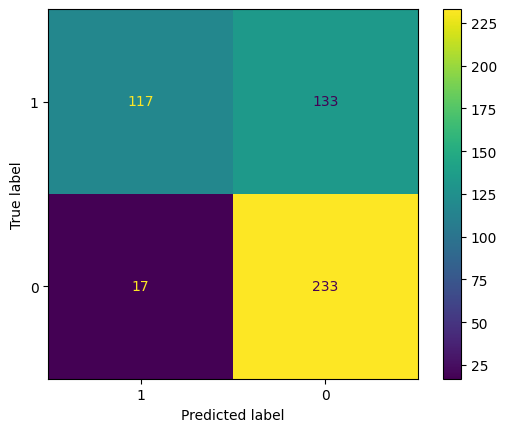

In [18]:
#performance for raw tweets
performance(test_df['related_manual'],test_df['related_zero_shot_tweet_original_bart'])

In [19]:
#zero shot prediction for cleaned tweets (BART)
%%time
test_df_cleaned['related_zero_shot_tweet_cleaned_bart'] = test_df_cleaned['tweet_preprocessed'].apply(zero_shot_learning_bart)

CPU times: user 1h 11min 50s, sys: 4min 3s, total: 1h 15min 54s
Wall time: 7min 10s


Accuracy: 78.068%
[155  95  14 233]
TP: 155
FP: 14
TN: 233
FN: 95
Sensitivity: 62.0%
Specificity: 94.332%
Precision: 91.716%
Recall: 62.0%
f1: 73.986%


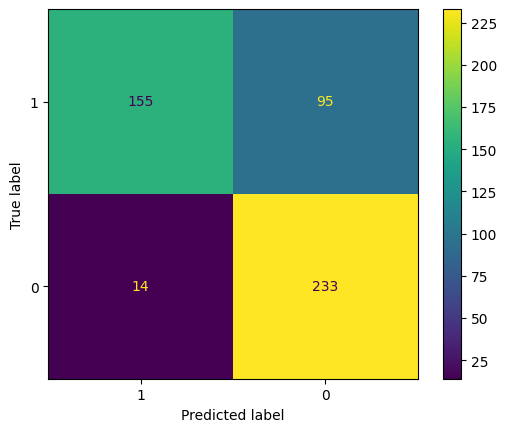

[inf  1.  0.]


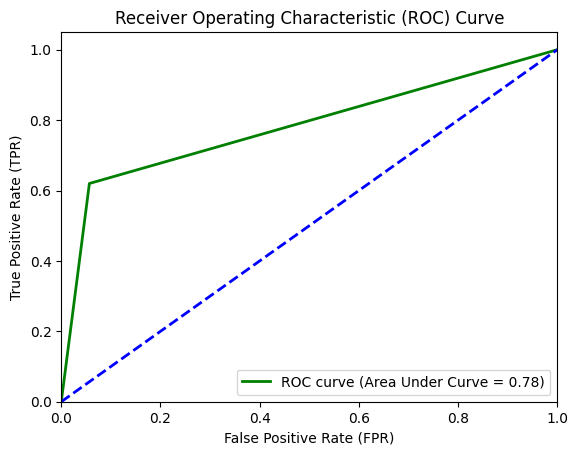

In [24]:
#performance for cleaned tweets
performance(test_df_cleaned['related_manual'], test_df_cleaned['related_zero_shot_tweet_cleaned_bart'], list(test_df_cleaned['related_zero_shot_tweet_cleaned_bart']))

<h2>Results<h2>

<h4>Raw tweets<h4>

|      Model      | Accuracy |  TP | FP |  TN |  FN | Sensitivity | Specificity | Precision | Recall | f1-score |
|:---------------:|:--------:|:---:|:--:|:---:|:---:|:-----------:|:-----------:|:---------:|:------:|:--------:|
| Zeroshot (BERT) |   79.4%  | 223 | 76 | 174 |  27 |    89.2%    |    69.6%    |  74.582%  |  89.2% |  81.239% |
| Zeroshot (BART) |   70.0%  | 117 | 17 | 233 | 133 |    46.8%    |    93.2%    |  87.313%  |  46.8% |  60.937% |

<h4>Cleaned tweets<h4>

|      Model      | Accuracy |  TP | FP |  TN | FN | Sensitivity | Specificity | Precision | Recall | f1-score |
|:---------------:|:--------:|:---:|:--:|:---:|:--:|:-----------:|:-----------:|:---------:|:------:|:--------:|
| Zeroshot (BERT) |  81.69%  | 244 | 85 | 162 |  6 |    97.6%    |   65.587%   |  74.164%  |  97.6% |  84.283% |
| Zeroshot (BART) |  78.068% | 155 | 14 | 233 | 95 |    62.0%    |   94.332%   |  91.716%  |  62.0% |  73.986% |